In [1]:
from itertools import product, repeat
import time
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from src.simulation import Simulation
from src.genetic import fitness
from src.bruteforce import BruteForcePlatform
from src.visualization import VisualizationFactory, VisualizationType

pygame 2.5.2 (SDL 2.28.3, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
p_min = -100
p_max = 101
p_div = 5.0

i_min = -100
i_max = 101
i_div = 500.0

d_min = -100
d_max = 101
d_div = 0.2

p = [x / p_div for x in range(p_min, p_max, 7)]
i = [x / i_div for x in range(i_min, i_max, 7)]
d = [x / d_div for x in range(d_min, d_max, 7)]

In [3]:
pid_combinations = list(product(p, i, d))
num_pid_combinations = len(pid_combinations)

num_pid_combinations

24389

In [4]:
fps = 30
setpoints = [-10] * fps * 10 + [5] * fps * 10 + [0] * fps * 40 + [8] * fps * 10 + [0] * fps * 10
external_force = [0] * fps * 30 + [1] * fps * 50
mass = 0.2
delta_t = 1 / fps
simulation = Simulation(mass=mass, delta_t=delta_t)
weight_factor = 0.4

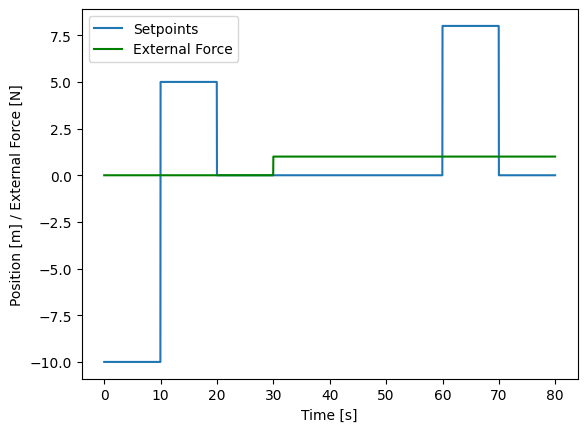

In [5]:
plt.plot(np.arange(len(setpoints)) / fps, setpoints)
plt.plot(np.arange(len(setpoints)) / fps, external_force, c='g')

plt.xlabel('Time [s]')
plt.ylabel('Position [m] / External Force [N]')
plt.legend(['Setpoints', 'External Force'])

plt.show()

In [6]:
num_cpus = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cpus)
start = time.time()
results = pool.starmap(
    BruteForcePlatform.execute,
    zip(
        pid_combinations, 
        repeat(mass), 
        repeat(delta_t), 
        repeat(setpoints), 
        repeat(external_force),
        repeat(fitness), 
        repeat(weight_factor)
    )
)
winner = results[np.argmin([result[3] for result in results])]
print(f'Simulated {round(((num_pid_combinations * len(setpoints)) / fps) / (60 * 60 * 24), 2)} days in {round(time.time() - start, 2)} seconds on {num_cpus} CPUs')
print(f'Error-Score: {winner[3]}')
print(f'P: {winner[0]}')
print(f'I: {winner[1]}')
print(f'D: {winner[2]}')

Simulated 22.58 days in 40.05 seconds on 8 CPUs
Error-Score: 696.8397479080827
P: -10.2
I: -0.018
D: -255.0


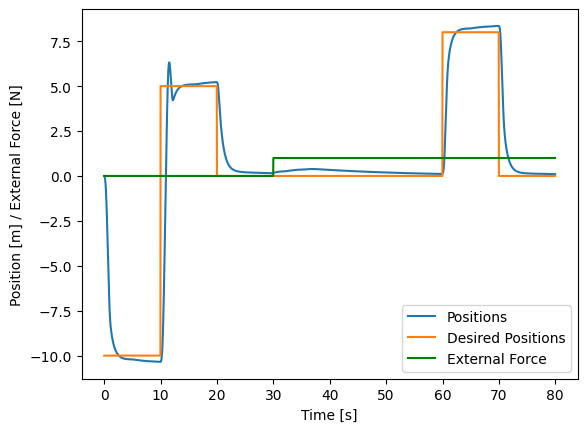

In [7]:
plt.plot(np.arange(len(setpoints)) / fps, winner[4])
plt.plot(np.arange(len(setpoints)) / fps, setpoints)
plt.plot(np.arange(len(setpoints)) / fps, external_force, c='g')

plt.xlabel('Time [s]')
plt.ylabel('Position [m] / External Force [N]')
plt.legend(['Positions', 'Desired Positions', 'External Force'])

plt.show()

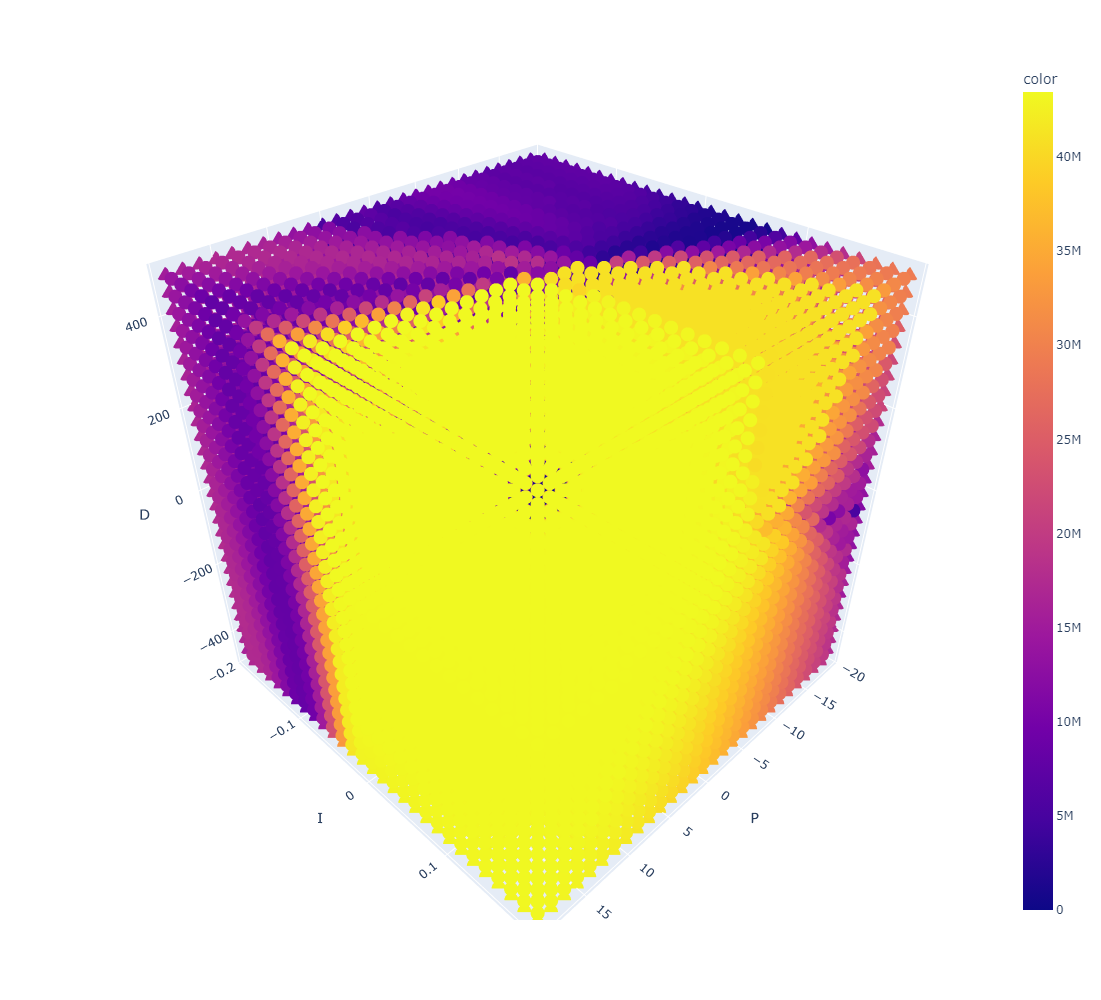

In [8]:
data = []
for x in results:
    data.append([x[0], x[1], x[2], x[3]])
data = np.array(data)

plot_data = {
    'P': data[:, 0],
    'I': data[:, 1],
    'D': data[:, 2]
}

fig = px.scatter_3d(plot_data, x='P', y='I', z='D', color=data[:, 3])
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[p_min / p_div, p_max / p_div]),
        yaxis=dict(range=[i_min / i_div, i_max / i_div]),
        zaxis=dict(range=[d_min / d_div, d_max / d_div])
    ),
    width=1000,
    height=1000,
)
fig.show()

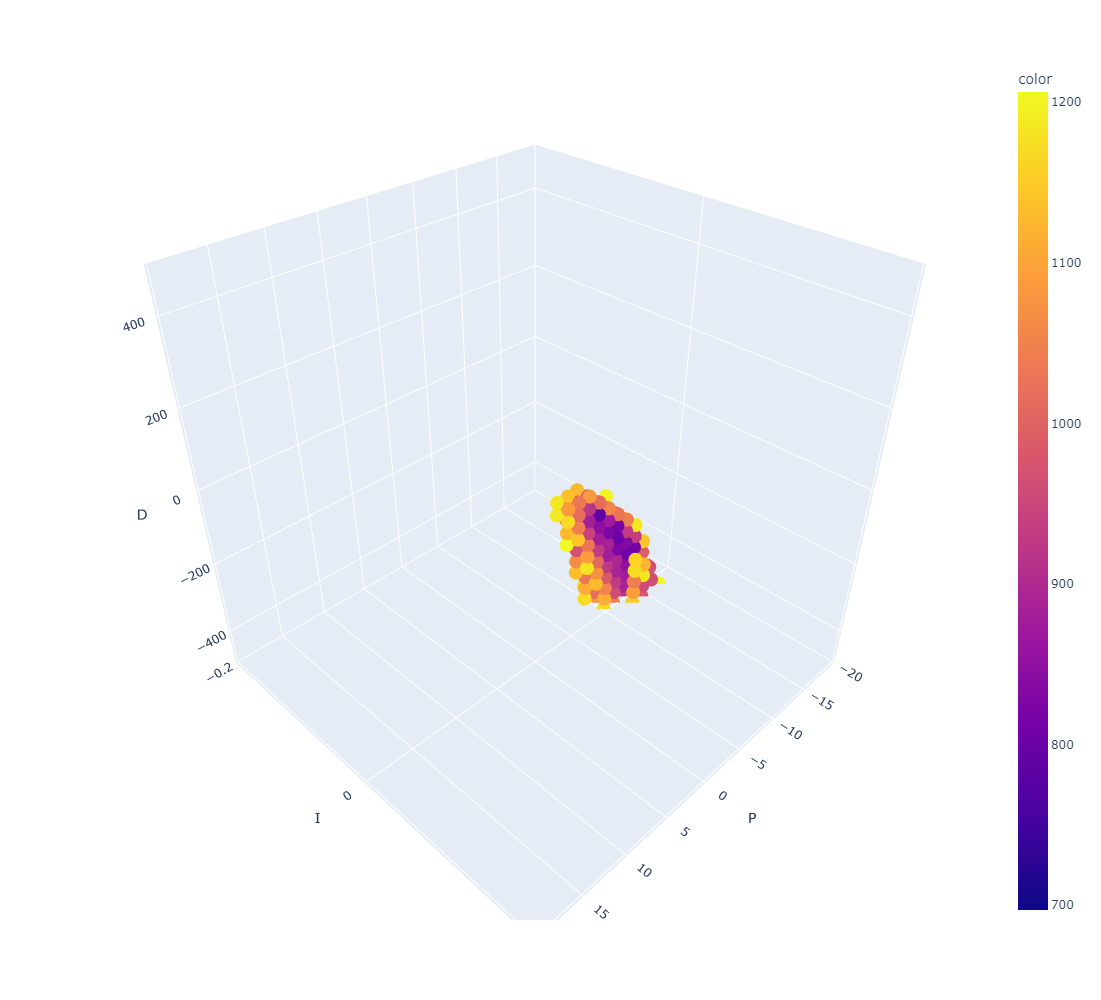

In [9]:
threshold = np.percentile(data[:, 3], 1)
filtered_data = data[np.where(data[:, 3] < threshold)]
plot_data = {
    'P': filtered_data[:, 0],
    'I': filtered_data[:, 1],
    'D': filtered_data[:, 2]
}

fig = px.scatter_3d(plot_data, x='P', y='I', z='D', color=filtered_data[:, 3])
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[p_min / p_div, p_max / p_div]),
        yaxis=dict(range=[i_min / i_div, i_max / i_div]),
        zaxis=dict(range=[d_min / d_div, d_max / d_div])
    ),
    width=1000,
    height=1000,
)
fig.show()

In [10]:
p = winner[0]
i = winner[1]
d = winner[2]
visualization = VisualizationFactory.create_visualization(VisualizationType.PID, kp=p, ki=i, kd=d)
visualization.run()